In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
lLevels=pd.read_json('light_levels.json')
lLevels.head(5)

,Date,Light Score
0,2010-09-26,4.0
1,2015-05-07,6.0
2,2012-03-07,NaN
3,2000-09-18,15.0
4,2000-11-10,15.0


In [3]:
lLevels.info

<bound method DataFrame.info of            Date  Light Score 
0    2010-09-26           4.0
1    2015-05-07           6.0
2    2012-03-07           NaN
3    2000-09-18          15.0
4    2000-11-10          15.0
...         ...           ...
3246 2018-05-03          14.0
3247 2001-11-07           3.0
3248 2012-09-03          17.0
3249 2002-03-23           3.0
3250 2015-08-28           3.0

[3251 rows x 2 columns]>

In [4]:
lLevels.describe()

,Light Score
count,3236.000000
mean,10.338690
std,5.279244
min,3.000000
25%,4.000000
50%,11.000000
75%,15.000000
max,17.000000


In [5]:
fCall=pd.read_json('flight_call.json')
fCall.head(5)

,Species,Family,Collisions,Flight,Call,Habitat,Stratum
0,Zonotrichia,albicollis,Passerellidae,10133,Yes,Forest,Lower
1,Junco,hyemalis,Passerellidae,6303,Yes,Edge,Lower
2,Melospiza,melodia,Passerellidae,5124,Yes,Edge,Lower
3,Melospiza,georgiana,Passerellidae,4910,Yes,Open,Lower
4,Seiurus,aurocapilla,Parulidae,4580,Yes,Forest,Lower


In [6]:
fCall.info

<bound method DataFrame.info of         Species       Family     Collisions  Flight Call Habitat Stratum
0   Zonotrichia   albicollis  Passerellidae   10133  Yes  Forest   Lower
1         Junco     hyemalis  Passerellidae    6303  Yes    Edge   Lower
2     Melospiza      melodia  Passerellidae    5124  Yes    Edge   Lower
3     Melospiza    georgiana  Passerellidae    4910  Yes    Open   Lower
4       Seiurus  aurocapilla      Parulidae    4580  Yes  Forest   Lower
..          ...          ...            ...     ...  ...     ...     ...
91    Empidonax     traillii     Tyrannidae     177   No    Open   Upper
92    Melospiza    georgiana  Passerellidae    4910  Yes    Open   Lower
93        Vireo       gilvus     Vireonidae       2   No  Forest   Upper
94        Vireo   flavifrons     Vireonidae      12   No  Forest   Upper
95      Certhia    americana     Certhiidae    2676  Yes  Forest   Upper

[96 rows x 7 columns]>

In [7]:
fCall.describe()

,Flight
count,96.000000
mean,807.927083
std,1602.275587
min,1.000000
25%,17.500000
50%,177.000000
75%,742.000000
max,10133.000000


In [8]:
cData = pd.read_json('chicago_collision_data.json')
cData.head(5)

,Genus,Species,Date,Locality
0,Ammodramus,nelsoni,1982-10-03,MP
1,Ammodramus,nelsoni,1984-05-21,CHI
2,Ammodramus,nelsoni,1984-05-25,MP
3,Ammodramus,nelsoni,1985-10-08,MP
4,Ammodramus,nelsoni,1986-09-10,MP


In [9]:
cData.info

<bound method DataFrame.info of              Genus     Species       Date Locality
0       Ammodramus     nelsoni 1982-10-03       MP
1       Ammodramus     nelsoni 1984-05-21      CHI
2       Ammodramus     nelsoni 1984-05-25       MP
3       Ammodramus     nelsoni 1985-10-08       MP
4       Ammodramus     nelsoni 1986-09-10       MP
...            ...         ...        ...      ...
69779    Melospiza     melodia 2016-10-19      CHI
69780    Melospiza     melodia 2016-10-30      CHI
69781  Zonotrichia     querula 2007-10-15       MP
69782  Zonotrichia     querula 2008-10-16       MP
69783  Zonotrichia  albicollis 2013-10-22      CHI

[69784 rows x 4 columns]>

In [10]:
cData.describe()

,Genus,Species,Date,Locality
count,69784,69784,69784,69784
unique,43,84,5318,2
top,Melospiza,albicollis,2013-10-08 00:00:00,MP
freq,12063,10133,364,36315
first,NaN,NaN,1978-09-15 00:00:00,NaN
last,NaN,NaN,2016-11-30 00:00:00,NaN


In [11]:
fCall.columns=["Genus","Species","Family","Flight","Flight Call","Habitat","Stratum"]
fCall.head(5)

,Genus,Species,Family,Flight,Flight Call,Habitat,Stratum
0,Zonotrichia,albicollis,Passerellidae,10133,Yes,Forest,Lower
1,Junco,hyemalis,Passerellidae,6303,Yes,Edge,Lower
2,Melospiza,melodia,Passerellidae,5124,Yes,Edge,Lower
3,Melospiza,georgiana,Passerellidae,4910,Yes,Open,Lower
4,Seiurus,aurocapilla,Parulidae,4580,Yes,Forest,Lower


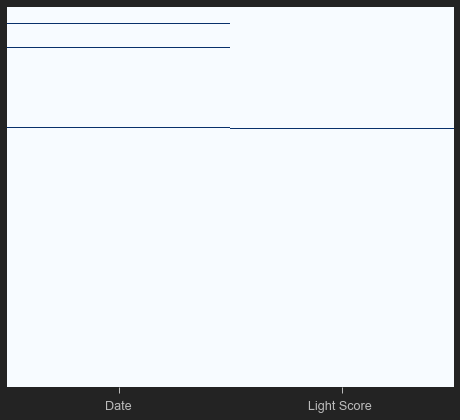

In [12]:
sns.heatmap(lLevels.isnull(),yticklabels=False, cbar=False, cmap="Blues")

In [13]:
lLevels.isnull().sum()

Date            15
Light Score     15
dtype: int64

In [14]:
lLevels.dropna(subset=lLevels.columns[[0,1]], inplace=True)
lLevels.isnull().sum()

Date            0
Light Score     0
dtype: int64

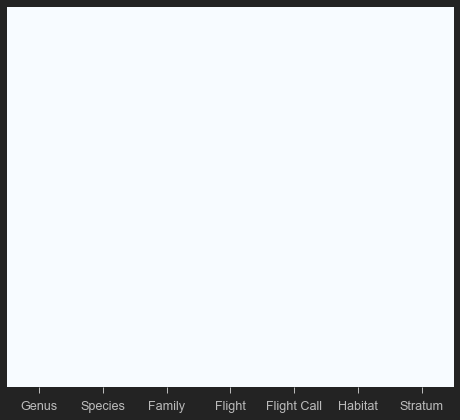

In [15]:
sns.heatmap(fCall.isnull(),yticklabels=False, cbar=False, cmap="Blues")

In [16]:
fCall.isnull().sum()

Genus          0
Species        0
Family         0
Flight         0
Flight Call    0
Habitat        0
Stratum        0
dtype: int64

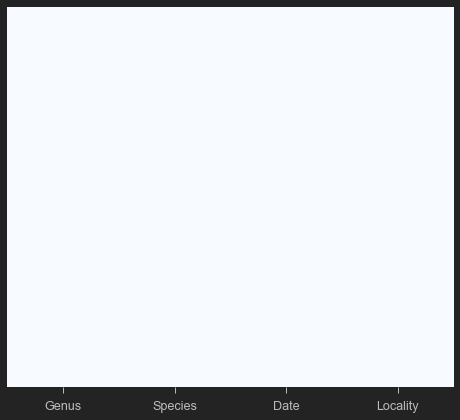

In [17]:
sns.heatmap(cData.isnull(),yticklabels=False, cbar=False, cmap="Blues")

In [18]:
cData.isnull().sum()

Genus       0
Species     0
Date        0
Locality    0
dtype: int64

In [19]:
df1 = pd.merge(lLevels,cData,on='Date')
df1.head(5)

,Date,Light Score,Genus,Species,Locality
0,2010-09-26,4.0,Catharus,guttatus,CHI
1,2010-09-26,4.0,Catharus,guttatus,CHI
2,2010-09-26,4.0,Catharus,guttatus,CHI
3,2010-09-26,4.0,Catharus,ustulatus,CHI
4,2010-09-26,4.0,Catharus,ustulatus,CHI


In [20]:
df1['sName']=df1.apply(lambda row: row.Genus.strip()+" "+row.Species.strip(),axis=1)
df1.head(5)

,Date,Light Score,Genus,Species,Locality,sName
0,2010-09-26,4.0,Catharus,guttatus,CHI,Catharus guttatus
1,2010-09-26,4.0,Catharus,guttatus,CHI,Catharus guttatus
2,2010-09-26,4.0,Catharus,guttatus,CHI,Catharus guttatus
3,2010-09-26,4.0,Catharus,ustulatus,CHI,Catharus ustulatus
4,2010-09-26,4.0,Catharus,ustulatus,CHI,Catharus ustulatus


In [21]:
df1=df1.drop(columns=["Genus","Species"])

In [22]:
fCall['sName']=fCall.apply(lambda row: row.Genus.strip()+" "+row.Species.strip(),axis=1)
fCall.head(5)

,Genus,Species,Family,Flight,Flight Call,Habitat,Stratum,sName
0,Zonotrichia,albicollis,Passerellidae,10133,Yes,Forest,Lower,Zonotrichia albicollis
1,Junco,hyemalis,Passerellidae,6303,Yes,Edge,Lower,Junco hyemalis
2,Melospiza,melodia,Passerellidae,5124,Yes,Edge,Lower,Melospiza melodia
3,Melospiza,georgiana,Passerellidae,4910,Yes,Open,Lower,Melospiza georgiana
4,Seiurus,aurocapilla,Parulidae,4580,Yes,Forest,Lower,Seiurus aurocapilla


In [23]:
df2 = pd.merge(df1,fCall,on='sName')
df2.head(5)

,Date,Light Score,Locality,sName,Genus,Species,Family,Flight,Flight Call,Habitat,Stratum
0,2010-09-26,4.0,CHI,Catharus guttatus,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
1,2010-09-26,4.0,CHI,Catharus guttatus,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
2,2010-09-26,4.0,CHI,Catharus guttatus,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
3,2007-10-22,15.0,CHI,Catharus guttatus,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
4,2007-10-22,15.0,CHI,Catharus guttatus,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower


In [24]:
df2.describe()

,Light Score,Flight
count,44265.000000,44265.000000
mean,10.783237,4230.308980
std,5.137912,3283.162271
min,3.000000,1.000000
25%,5.000000,1555.000000
50%,12.000000,3729.000000
75%,16.000000,6303.000000
max,17.000000,10133.000000


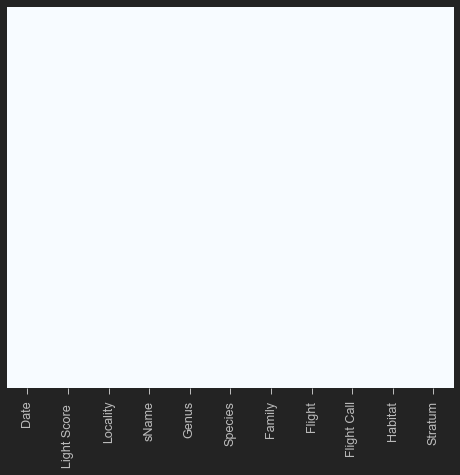

In [25]:
sns.heatmap(df2.isnull(),yticklabels=False, cbar=False, cmap="Blues")

In [26]:
df2=df2.drop(columns=["sName"])
df2.head(5)

,Date,Light Score,Locality,Genus,Species,Family,Flight,Flight Call,Habitat,Stratum
0,2010-09-26,4.0,CHI,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
1,2010-09-26,4.0,CHI,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
2,2010-09-26,4.0,CHI,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
3,2007-10-22,15.0,CHI,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower
4,2007-10-22,15.0,CHI,Catharus,guttatus,Turdidae,3729,Yes,Forest,Lower


In [27]:
df2["Date"] = pd.to_datetime(df2["Date"])
df2 = df2.sort_values(by="Date")
df2.head(10)

,Date,Light Score,Locality,Genus,Species,Family,Flight,Flight Call,Habitat,Stratum
39377,2000-03-06,3.0,MP,Spizelloides,arborea,Passerellidae,1262,Yes,Edge,Lower
40596,2000-03-06,3.0,MP,Melospiza,melodia,Passerellidae,5124,Yes,Edge,Lower
13637,2000-03-06,3.0,MP,Junco,hyemalis,Passerellidae,6303,Yes,Edge,Lower
40597,2000-03-06,3.0,MP,Melospiza,melodia,Passerellidae,5124,Yes,Edge,Lower
39198,2000-03-08,15.0,MP,Spizelloides,arborea,Passerellidae,1262,Yes,Edge,Lower
39199,2000-03-08,15.0,MP,Spizelloides,arborea,Passerellidae,1262,Yes,Edge,Lower
35748,2000-03-08,15.0,MP,Passerella,iliaca,Passerellidae,2443,Yes,Edge,Lower
39200,2000-03-08,15.0,MP,Spizelloides,arborea,Passerellidae,1262,Yes,Edge,Lower
35749,2000-03-08,15.0,MP,Passerella,iliaca,Passerellidae,2443,Yes,Edge,Lower
35750,2000-03-08,15.0,MP,Passerella,iliaca,Passerellidae,2443,Yes,Edge,Lower


In [28]:
df2.columns

Index(['Date', 'Light Score ', 'Locality', 'Genus', 'Species', 'Family',
       'Flight', 'Flight Call', 'Habitat', 'Stratum'],
      dtype='object')

In [ ]:
def main(light_levels,collision_data,flight_call,output_file):
    #Load .json files to DataFrames
    lLevels=pd.read_json(light_levels)
    cData = pd.read_json(collision_data)
    fCall=pd.read_json(flight_call)
    
    #Correct the fCall DataFrame columns as given in the .docx file
    fCall.columns=["Genus","Species","Family","Flight","Flight Call","Habitat","Stratum"]
    
    #Remove rows containing NaN values from all the DataFrames
    lLevels.dropna(subset=lLevels.columns[[0,1]], inplace=True)
    cData.dropna(subset=cData.columns[[0,1,2,3]], inplace=True)
    fCall.dropna(subset=fCall.columns[[0,1,2,3,4,5,6]], inplace=True)
    
    #Merge lLevels DataFrame and cData based on the Date column
    df1 = pd.merge(lLevels,cData,on='Date')
    
    #After merging that we need to merge df1 and fCall DataFrames. To do that we need to find a common column.
    #The common columns available in those DataFrames are Genus and Species.
    #So we will create a column called sName specifying "Specific Name"
    
    